# Evaluate Rate of ML Update
Assess the performance of the machine learning updating logic during the coarse of a Colmena run

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import re

In [2]:
log_re = r"^(?P<date>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - (?P<module>\S+) - (?P<level>[A-Z]+) - (?P<message>[\s\S]*?)(?=^\d{4})"

Load the run information 

In [3]:
run_info = pd.read_csv('../run_data.csv')

In [4]:
run_info = run_info.sort_values('start_time', ascending=False).iloc[0].to_dict()
#run_info = run_info.query('path=="runs/10Nov20-210002-b59342"').iloc[0]  # XTB run
run_info

{'path': 'runs/15Dec20-074345-dca458',
 'param_hash': 'dca458',
 'start_time': '2020-12-15 07:43:04',
 'mpnn_config_directory': '../../ai-components/mpnn/nwchem-atomization-v0/',
 'mpnn_model_files': "['../../ai-components/mpnn/nwchem-atomization-v0/best_model.h5', '../../ai-components/mpnn/nwchem-atomization-v0/networks/b32_n512_S10/best_model.h5', '../../ai-components/mpnn/nwchem-atomization-v0/networks/b32_n512_S11/best_model.h5', '../../ai-components/mpnn/nwchem-atomization-v0/networks/b32_n512_S12/best_model.h5']",
 'initial_agent': '../../ai-components/moldqn/nwchem-atomization-v0//agent.pkl',
 'initial_search_space': '../../ai-components/moldqn/nwchem-atomization-v0//best_mols.json',
 'initial_database': '../../ai-components/mpnn/nwchem-atomization-v0//initial_database.json',
 'qc_spec': 'small_basis',
 'qc_parallelism': 2,
 'parallel_updating': 2,
 'rl_episodes': 10,
 'search_size': 1000,
 'queue_length': 1024,
 'random_frac': 0.1,
 'greedy_frac': 0.8,
 'nnodes': 256,
 'ml_node

## Load in the Trajectories
We need the records associated with QC records and model update tasks

In [5]:
result_data = pd.read_json(os.path.join('..', run_info['path'], 'simulation_records.jsonld'), lines=True)
result_data.sort_values('time_created', inplace=True)

In [6]:
update_records = pd.read_json(os.path.join('..', run_info['path'], 'update_records.jsonld'), lines=True)

In [7]:
screen_records = pd.read_json(os.path.join('..', run_info['path'], 'screen_records.jsonld'), lines=True)

Process the result log

In [8]:
with open(os.path.join('..', run_info['path'], 'runtime.log')) as fp:
    log_lines = fp.read()

In [9]:
log_data = pd.DataFrame([x.groupdict() for x in re.finditer(log_re, log_lines, re.MULTILINE)])
del log_lines
print(f'Parsed {len(log_data)} log lines')

Parsed 7345 log lines


In [10]:
log_data['datetime'] = log_data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S,%f').timestamp())

Find records associated with a molecule being submitted

In [11]:
molecule_submission = log_data[np.logical_and(log_data['module'] == "thinker.simulation_dispatcher", log_data['message'].str.startswith('Submitted'))]

## Measure Time-to-Updated
Measure the time until any or all models are updated with the result from a tasks

In [12]:
n_models = len(eval(run_info['mpnn_model_files']))

In [13]:
row = update_records.iloc[0]

In [14]:
def is_in_training_set(smiles):
    """Measure if a molecule is in the training set of the models after each training operation
    
    Args:
        smiles (str): SMILES string
    Returns:
        (ndarray) Whether the molecule is in the training set for each model after each update operation
    """
    
    output = np.zeros((len(update_records), n_models), dtype=np.bool)
    for i, row in update_records.iterrows():
        output[i:, row['task_info']['index']] = smiles in row['task_info']['training_molecules']
    return output

In [15]:
def time_until_updated(smiles: str, t0: float) -> np.ndarray:
    """Compute time data from a molecule is used to re-train models
    
    Args:
        smiles: SMILES string of a molecule
        t0: Time that the properties finished computing
    Returns:
        (np.ndarray) Time until molecule appears in each training set
    """
    
    # Get whether the molecule is in the training set after each update operation
    is_in_set = is_in_training_set(smiles)
    
    # Compute number of models that have been trained with molecule at each update
    n_updated = is_in_set.sum(axis=1)
    
    # Compute time until [1, N) models have been trained using this data
    output = np.zeros((n_models,)) + np.inf
    for i in range(1, n_models+1):
        if i <= n_updated.max():
            output[i-1] = update_records['time_result_received'].iloc[
                (n_updated == i).argmax()
            ]
    output -= t0
    return output

In [16]:
result_statistics = []
for i, result in tqdm(result_data.query('success').iterrows()):
    # Get the time until model was updated
    update_timings = time_until_updated(result['task_info']['smiles'], result['time_result_received'])
    
    # Store the time until model updates
    record = dict(zip(map(lambda x: f'updated_{x+1}', range(n_models)), update_timings))
    record['updated_all'] = update_timings[-1]
    
    # Count the number of decisions made between "data acquired" and "models updated"
    for i in range(n_models):
        record[f'n_uninformed_{i+1}'] = np.logical_and(
            molecule_submission['datetime'] >= result['time_result_received'],
            molecule_submission['datetime'] <= result['time_result_received'] + record[f'updated_{i+1}']
        ).sum()
    record['n_uninformed_all'] = record[f'n_uninformed_{i+1}']
    
    # Store the molecule information
    record.update(result['task_info'])
    for l in ['time_result_received', 'time_created']:
        record[l] = result[l]
    result_statistics.append(record)

174it [00:03, 44.81it/s]


In [17]:
result_statistics = pd.DataFrame(result_statistics)

Compute the time to update

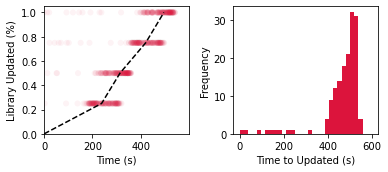

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

# Plot the change over time
ax = axs[0]
medians = [0]
for i in range(n_models):
    r = result_statistics[f'updated_{i+1}']
    r = r[~ r.isnull()]
    ax.scatter(r, [(i+1) / n_models]*len(r), 
               color='crimson', alpha=0.05, edgecolor='none')
    non_nans = result
    medians.append(np.percentile(r, 50))
    
ax.plot(medians, np.arange(0, n_models+1) / n_models, 'k--')

ax.set_xlim([-0, max(ax.get_xlim())])
ax.set_ylim([0, 1.05])  
ax.set_xlabel('Time (s)')
ax.set_ylabel('Library Updated (%)')

# Plot the histogram
ax = axs[1]

actual_max = np.max(result_statistics['updated_all'][~np.isinf(
    result_statistics['updated_all']
)])
bins = np.linspace(0, actual_max * 1.1, 32)
ax.hist(result_statistics['updated_all'], bins=bins, color='crimson')

ax.set_ylabel('Frequency')
ax.set_xlabel('Time to Updated (s)')

fig.tight_layout()

Determine the number of "uninformed decisions"

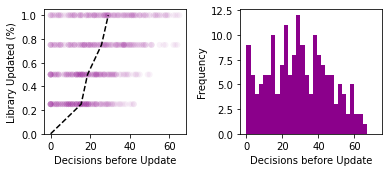

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(5.5, 2.5))

# Plot the change over time
ax = axs[0]
medians = [0]
for i in range(n_models):
    r = result_statistics[f'n_uninformed_{i+1}']
    r = r[~ r.isnull()]
    ax.scatter(r, [(i+1) / n_models]*len(r), 
               color='darkmagenta', alpha=0.05, edgecolor='none')
    non_nans = result
    medians.append(np.mean(r))
    
ax.plot(medians, np.arange(0, n_models+1) / n_models, 'k--')

#ax.set_xlim([0, max(ax.get_xlim())])
ax.set_ylim([0, 1.05])  
ax.set_xlabel('Decisions before Update')
ax.set_ylabel('Library Updated (%)')

# Plot the histogram
ax = axs[1]

bins = np.linspace(0, result_statistics['n_uninformed_all'].max() * 1.1, 32)
ax.hist(result_statistics['n_uninformed_all'], bins=bins, color='darkmagenta')

ax.set_ylabel('Frequency')
ax.set_xlabel('Decisions before Update')

fig.tight_layout()

## Time until Reprioritization
Compute the time until the models are fully updated with new data _and_ that model has been used to re-prioritize the task list.

Get the times at which the queue was updated

In [20]:
queue_update_events = log_data[np.logical_and(
    log_data['module'] == "thinker.task_ranker", log_data["message"].str.startswith("Added all of them")
)].sort_values('datetime', ascending=True)

In [21]:
def time_until_reprioritization(smiles: str, t0: float) -> float:
    """Compute time data from a molecule is used to re-train models
    
    Args:
        smiles: SMILES string of a molecule
        t0: Time that the properties finished computing
    Returns:
        (float) Time until data used in all models in an inference task
    """
    
    # Get whether the molecule is in the training set after each screening operation
    is_in_set = [all(smiles in t for t in r['task_info']['training_sets'])
                for _, r in screen_records.iterrows()]
    
    # Get the time the first inference task was completed
    if not any(is_in_set):
        return np.inf
    first_repri = is_in_set.index(True)

    return queue_update_events.iloc[first_repri]['datetime'] - t0

Compute this time for all entries

In [22]:
result_data['reprioritization_time'] = [time_until_reprioritization(d['smiles'], t) for d, t in 
                                        tqdm(zip(result_data['task_info'], result_data['time_result_received']))]

351it [00:01, 229.54it/s]


Plot whether data was used or not over time received

Text(0, 0.5, 'Used in an Update')

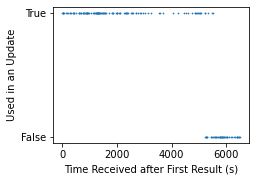

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

subset = result_data.sort_values('time_result_received').query('success')
not_used = np.isinf(subset['reprioritization_time'])

ax.scatter(subset['time_result_received'] - subset['time_result_received'].min(),
           1 - not_used, s=0.5)

ax.set_yticks([0, 1])
ax.set_yticklabels(['False', 'True'])

ax.set_xlabel('Time Received after First Result (s)')
ax.set_ylabel('Used in an Update')

*Finding*: Gut check passes.Tasks that completed early in simulation are used. Later ones are not

Text(0, 0.5, 'Frequency')

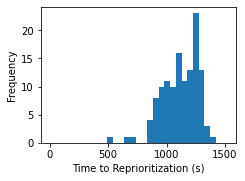

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Get only the tasks that were used
subset = subset[~not_used]
bins = np.linspace(0, subset['reprioritization_time'].max() * 1.1, 32)

ax.hist(subset['reprioritization_time'], bins=bins)

ax.set_xlabel('Time to Reprioritization (s)')
ax.set_ylabel('Frequency')

Measure the number of simulations between 

In [25]:
subset['n_uninformed'] = subset.apply(lambda x: np.logical_and(
    molecule_submission['datetime'] >= x['time_result_received'],
    molecule_submission['datetime'] <= x['time_result_received'] + x['reprioritization_time']
).sum(), axis=1)

Text(0, 0.5, 'Frequency')

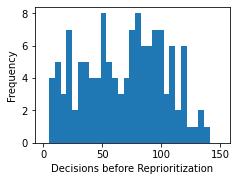

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

bins = np.linspace(0, subset['n_uninformed'].max() * 1.1, 32)
ax.hist(subset['n_uninformed'], bins=bins)

ax.set_xlabel('Decisions before Reprioritization')
ax.set_ylabel('Frequency')